In [ ]:
!pip install econml
!pip uninstall -y numpy scipy econml
!pip install --upgrade numpy scipy econml

# Import Libraries

In [ ]:
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import shap

%matplotlib inline

# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [ ]:
import sklearn, matplotlib, seaborn, econml
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"EconML version: {econml.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {seaborn.__version__}")

Pandas version: 2.2.2
Numpy version: 1.26.4
Scikit-learn version: 1.5.2
EconML version: 0.15.1
Matplotlib version: 3.10.0
Seaborn version: 0.13.2


# Dataset

## Useful functions

In [ ]:
# This function converts the future prices (in cent/lb) in 16 fl oz (the spot price units)
def futures_to_bls_price(futures_price_cents):
    price_per_lb = futures_price_cents / 100  # from ¢/lb to $/lb
    juice_per_lb_liters = 1.66  # 1 lb of concentrated = 1.66 liters of rehydrate juice
    oz_per_liter = 33.814  # numbers of fl oz in 1 liter
    fl_oz_target = 16  # target = 16 fl oz (473.2 ml)

    # Conversion in $ per 16 fl oz
    return price_per_lb * (1 / juice_per_lb_liters) * (fl_oz_target / oz_per_liter)

## Upload dataset

**OJ Dataset – Description**

The OJ dataset includes a variety of economic and market variables related to orange juice. It is designed to analyze price dynamics, consumer trends, and speculative activity in the futures market. The main variables are:

* **Futures contracts** and **trading volume**

* **Global orange price**

* **General inflation** and **Consumer Price Index (CPI)**

* **Average consumer price** of orange juice

* **Speculative indicators**: SNPI, NSP, ASA, Long MM, Short MM

**Futures Prices**

Futures prices for frozen concentrated orange juice (FCOJ) were sourced from [Yahoo Finance – OJ=F](https://www.google.com/url?q=https%3A%2F%2Fca.finance.yahoo.com%2Fquote%2FOJ%253DF%2F), which provides real-time market data on exchange-traded contracts.

**Consumer and Market Price Data**

To capture spot and consumer-level pricing trends, we used the following sources from FRED:
* **Average consumer price** of orange juice: [APU0000713111](https://www.google.com/url?q=https%3A%2F%2Ffred.stlouisfed.org%2Fseries%2FAPU0000713111)
* **Consumer Price Index (CPI)** – All Urban Consumers: [CUUR0000SAF114](https://www.google.com/url?q=https%3A%2F%2Ffred.stlouisfed.org%2Fseries%2FCUUR0000SAF114)
* **Global orange prices**: [PORANGUSDM](https://www.google.com/url?q=https%3A%2F%2Ffred.stlouisfed.org%2Fseries%2FPORANGUSDM)
* **General inflation (USA)**: [FPCPITOTLZGUSA](https://www.google.com/url?q=https%3A%2F%2Ffred.stlouisfed.org%2Fseries%2FFPCPITOTLZGUSA)

**Speculative Indicators (CFTC – Commitments of Traders)**

To evaluate speculative activity in the orange juice futures market, we used weekly COT reports published by the [CFTC](https://www.google.com/url?q=https%3A%2F%2Fwww.cftc.gov%2FMarketReports%2FCommitmentsofTraders%2FHistoricalCompressed%2Findex.htm). From this data, the following indicators were computed:

* **Net Speculative Position (NSP)**: The difference between long and short positions held by non-commercial traders.

* **Speculative Net Position Index (SNPI)**: The ratio of net speculative positions to total open interest, reflecting speculative sentiment strength.

* **Absolute Speculative Activity (ASA)**: The total speculative participation, calculated as the sum of long and short positions (absolute values), regardless of market direction.

Moreover, **seasonality** is a key factor influencing market dynamics, as both production cycles and seasonal consumption patterns significantly affect pricing behavior. The FCOJ futures market, in particular, is prone to price volatility during two critical periods:
* The Atlantic hurricane season in the United States (**June 1 – November 30**), and
* The Florida freeze season (**late November – March**), when frost can damage orange crops.

In [ ]:
file_name = "oj_data.xlsx"

In [ ]:
oj_data = pd.read_excel(file_name)
if 'Unnamed: 0' in oj_data.columns:
    oj_data = oj_data.drop(columns=['Unnamed: 0'])
oj_data.head()

# Extract the month from the 'observation_date' column
oj_data['Month'] = oj_data['observation_date'].dt.month

# Create dummy variables for the seasonality
oj_data['is_hurricane'] = oj_data['Month'].between(6, 11).astype(int)
oj_data['is_frost'] = oj_data['Month'].isin([12, 1, 2, 3]).astype(int)
oj_data['is_good_period'] = oj_data['Month'].isin([4, 5]).astype(int)

# Convert future prices into spot prices
oj_data['Close_Converted'] = oj_data['Close'].apply(futures_to_bls_price)

# Addressing the reverse causality moving the spot price
oj_data['APU0000713111'] = oj_data['APU0000713111'].shift(-1)
oj_data = oj_data.dropna(subset=['APU0000713111']).reset_index(drop=True)

## Evaluate ASA levels

We aim to investigate the heterogeneous effects of our variables with respect to market speculation intensity, using ASA as a proxy. In our analysis, ASA is treated as a **moderator variable**.

To assess the effects across different levels of speculation—high, medium, and low—we classified ASA values based on statistical thresholds:

* **Medium** ASA corresponds to values within one standard deviation of the mean

* **High** ASA includes values above mean + 1 standard deviation

* **Low** ASA includes values below mean − 1 standard deviation

In [ ]:
asa_mean = np.mean(oj_data['ASA'])
asa_std = np.std(oj_data['ASA'])
print(f"Average ASA: {asa_mean:.2f}, Standard Deviation ASA: {asa_std:.2f}")
print(f"ASA value: low if less than {asa_mean - asa_std:.2f} or high if greater than {asa_mean + asa_std:.2f}")

# Define bins for low, medium, and high ASA
low_asa_threshold = asa_mean - asa_std
high_asa_threshold = asa_mean + asa_std

# Create a new column to categorize ASA values
oj_data['ASA_Category'] = 'Medium'
oj_data.loc[oj_data['ASA'] <= low_asa_threshold, 'ASA_Category'] = 'Low'
oj_data.loc[oj_data['ASA'] >= high_asa_threshold, 'ASA_Category'] = 'High'

Average ASA: 7260.15, Standard Deviation ASA: 4089.54
ASA value: low if less than 3170.61 or high if greater than 11349.68


## Comparison with other markets

The FCOJ futures market is characterized by relatively low liquidity compared to other commodities such as wheat (SRW) and natural gas. To quantify this difference, we compare the levels of Absolute Speculative Activity (ASA) across these markets.

The ASA data were obtained from the Commitments of Traders (COT) reports published by the [CFTC](https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalCompressed/index.htm).

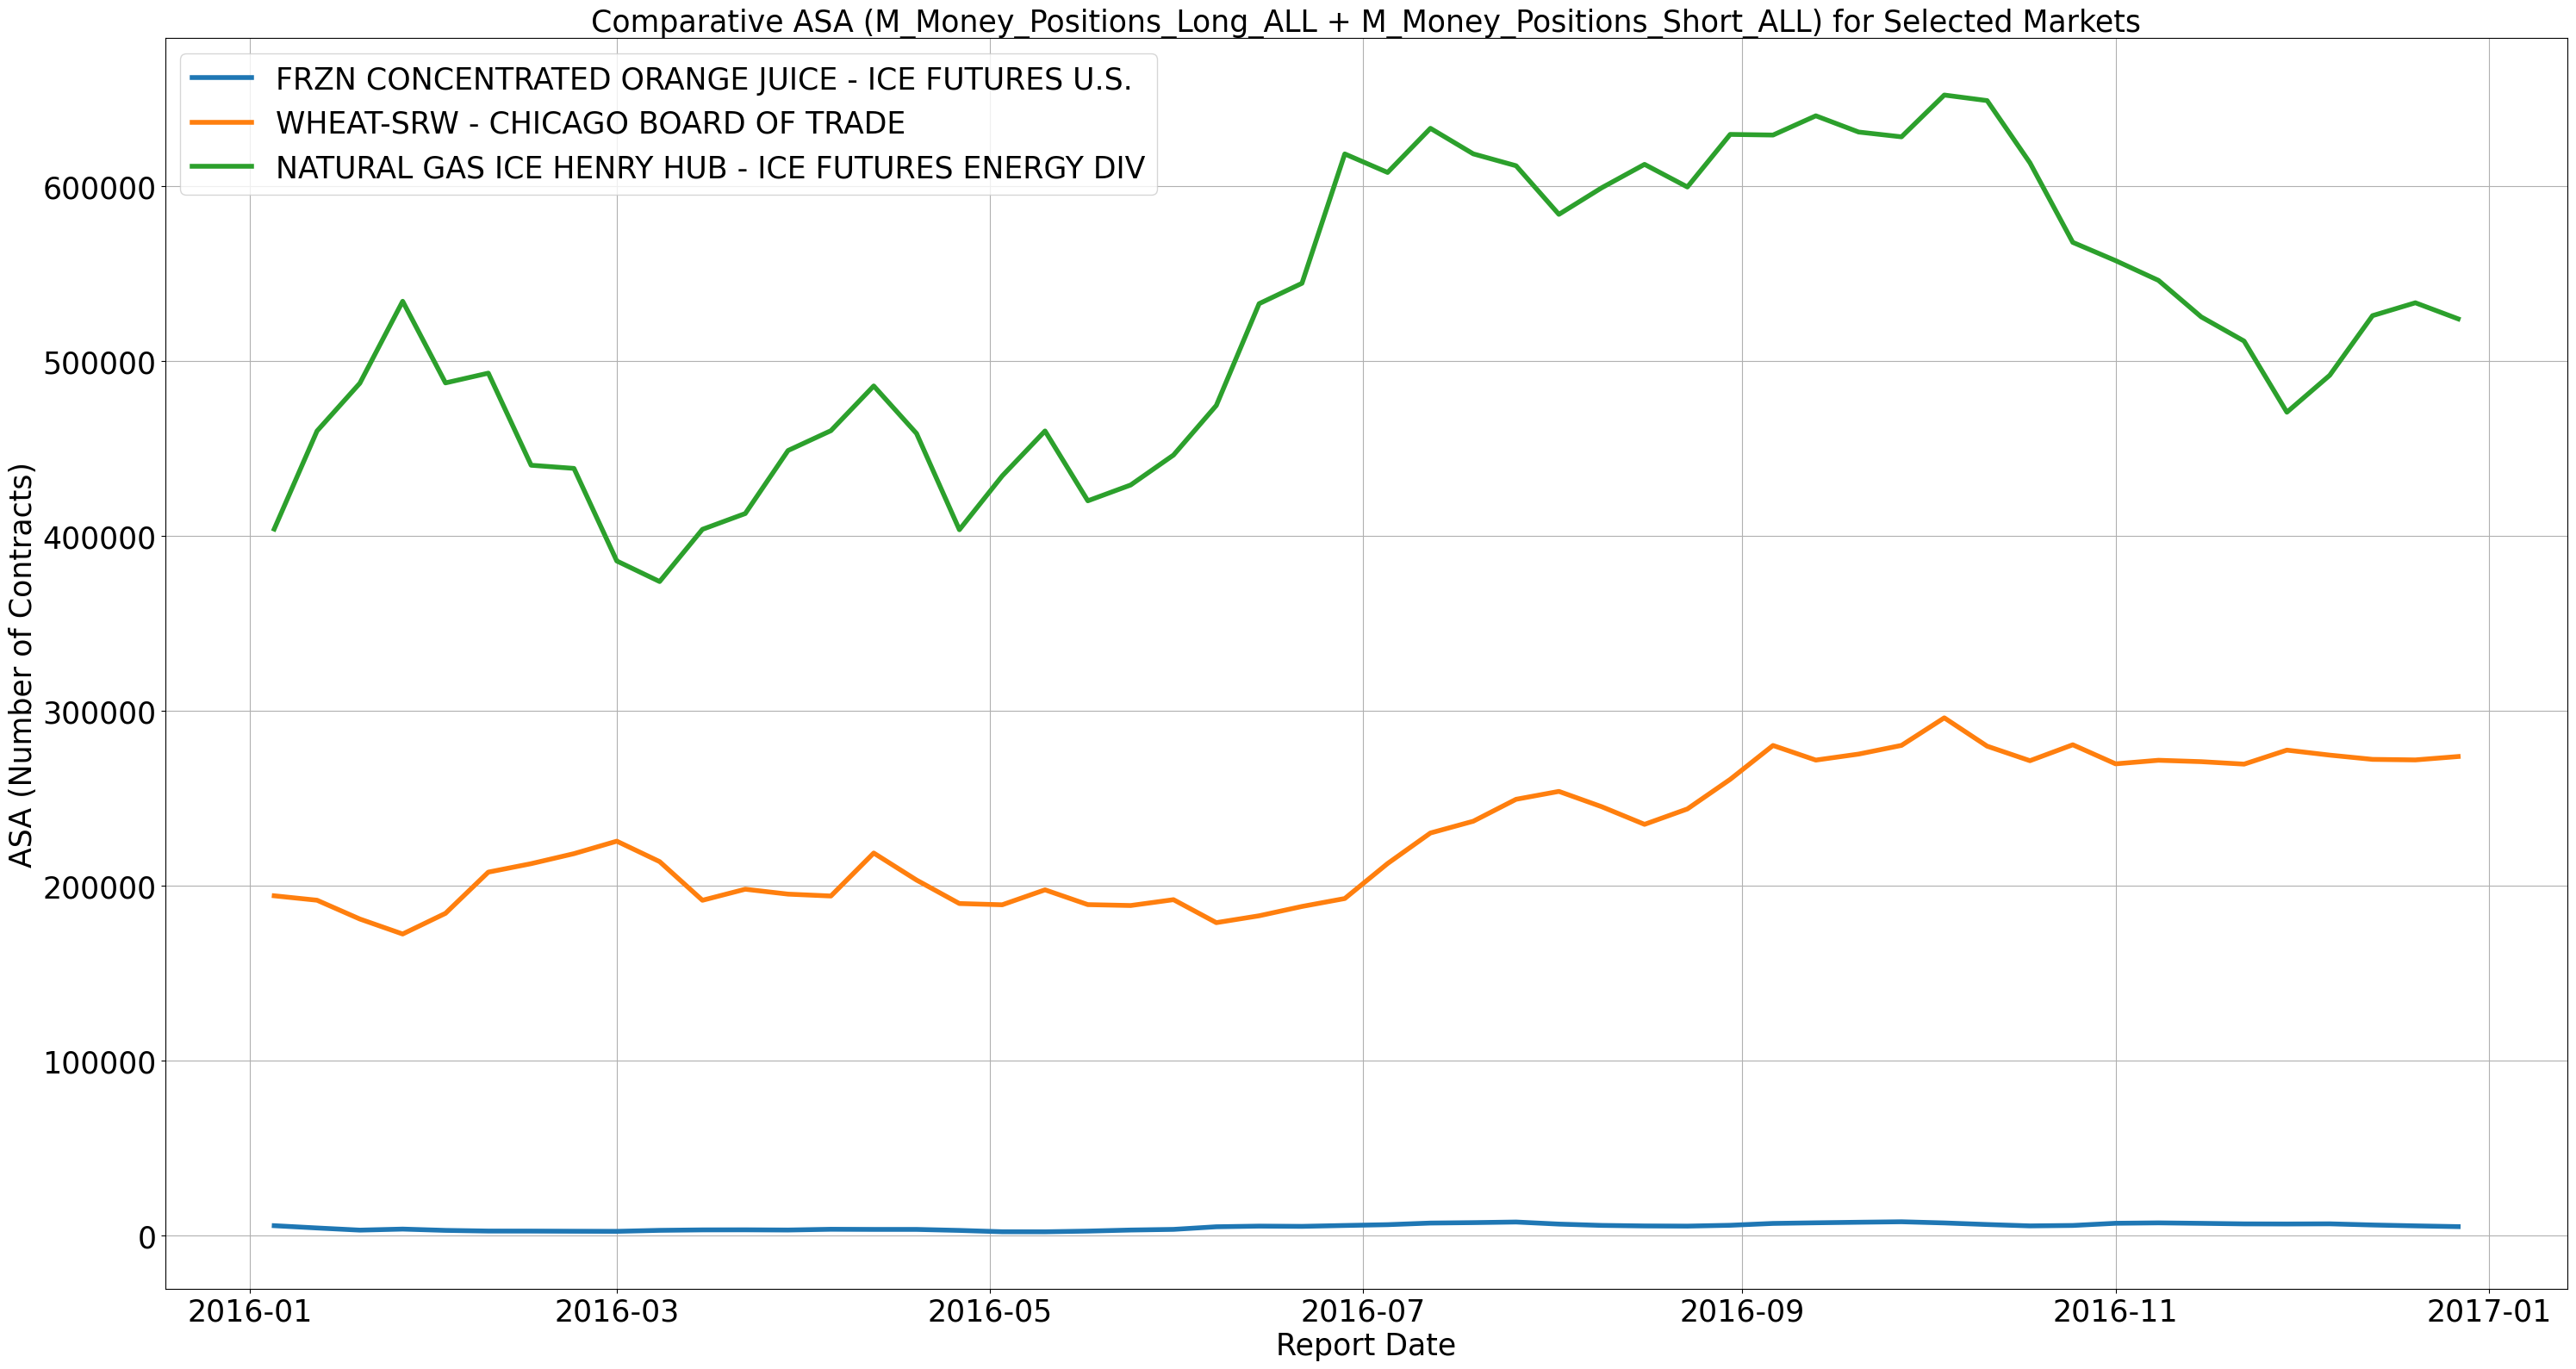

In [ ]:
cot = pd.read_excel('cot.xls')

# Calculate ASA for the relevant markets
cot['ASA'] = cot['M_Money_Positions_Long_ALL'] + cot['M_Money_Positions_Short_ALL']

# Define the markets to plot
markets_to_plot = [
    'FRZN CONCENTRATED ORANGE JUICE - ICE FUTURES U.S.',
    'WHEAT-SRW - CHICAGO BOARD OF TRADE',
    'NATURAL GAS ICE HENRY HUB - ICE FUTURES ENERGY DIV'
]

plt.figure(figsize=(30, 16))

fontsize=25

# Plot ASA for each market
for market in markets_to_plot:
    market_data = cot[cot['Market_and_Exchange_Names'] == market].copy()
    market_data['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(market_data['Report_Date_as_MM_DD_YYYY'])
    market_data = market_data.sort_values('Report_Date_as_MM_DD_YYYY') # Sort by date

    if not market_data.empty:
        plt.plot(market_data['Report_Date_as_MM_DD_YYYY'], market_data['ASA'], label=market, linewidth=4)
    else:
        print(f"No data found for market: {market}")

plt.title('Comparative ASA (M_Money_Positions_Long_ALL + M_Money_Positions_Short_ALL) for Selected Markets', fontsize=fontsize)
plt.xlabel('Report Date', fontsize=fontsize)
plt.ylabel('ASA (Number of Contracts)', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.grid(True)
plt.tight_layout()
plt.show()

# Causal Machine Learning Framework

The framework to be defined is as follows:

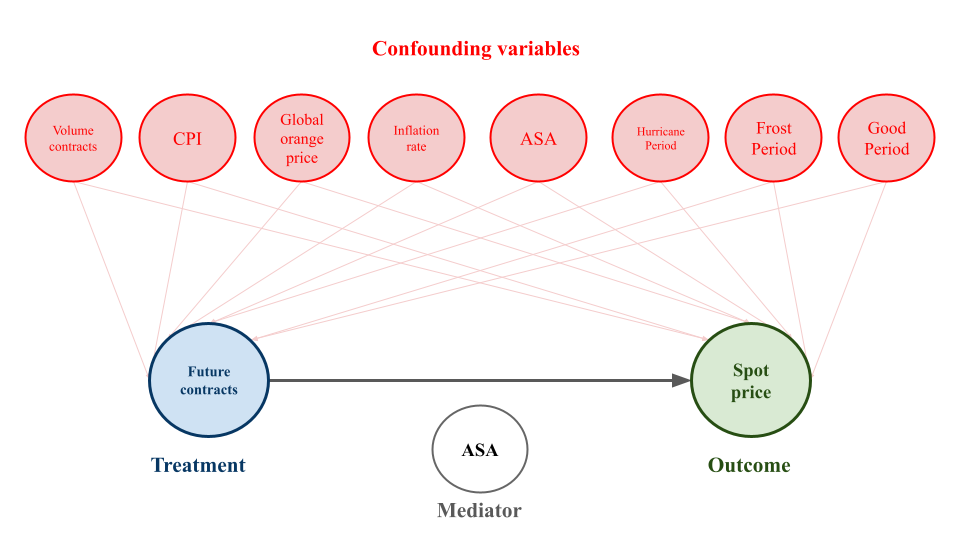

## Useful functions

In [ ]:
def causal_inference(oj_data, treatment, outcome, het, conf, model):
  # Treatment: variation of future prices
  T = oj_data[treatment].values[:]

  # Outcome: variation of spot prices
  Y = oj_data[outcome].values[:]

  # Mediator: ASA
  X = oj_data[het].values[:]

  # Confoundings: inflation, volume of future contracts, cpi, etc...
  W = oj_data[conf].values[:]

  # Standardize W
  scaler = StandardScaler()
  W = scaler.fit_transform(W)

  # Define some parameters
  n_trees = 1000
  min_leaf_size = 10
  max_depth = 10
  subsample_ratio = 0.6

  if model.lower() == 'ortho':
    est = DMLOrthoForest(
            n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth,
            subsample_ratio=subsample_ratio,
            model_T=Lasso(alpha=0.1),
            model_Y=Lasso(alpha=0.1),
            model_T_final=WeightedLassoCVWrapper(cv=3),
            model_Y_final=WeightedLassoCVWrapper(cv=3),
            random_state=123
          )
  else:
    est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                          model_t=WeightedLassoCVWrapper(cv=3),
                          n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                          max_samples=subsample_ratio/2,
                          random_state=123)

  est.fit(Y, T, X=X, W=W)

  # Defining a X_test for sorted ASA values
  X_test_raw = oj_data[het].values[:]
  X_test = X_test_raw[np.argsort(X_test_raw.flatten())]

  # Calculate marginal treatment effects
  treatment_effects = est.const_marginal_effect(X_test)

  # Calculate default (95%) marginal confidence intervals for the test data
  te_lower, te_upper = est.const_marginal_effect_interval(X_test)

  res = est.effect_inference(X_test)
  return est, res, treatment_effects, te_lower, te_upper, X_test

In [ ]:
def evaluate_conditional_treatment_effect(oj_data, treatment, outcome, het, conf, low_asa_threshold, high_asa_threshold, fontsize=20, figsize=(20, 6)):

    # Evaluate the CATE with the two models
    est1, res1, treatment_effects1, te_lower1, te_upper1, X_test = causal_inference(oj_data, treatment, outcome, het, conf, 'ortho')
    est2, res2, treatment_effects2, te_lower2, te_upper2, X_test = causal_inference(oj_data, treatment, outcome, het, conf, 'causal')

    p_values1 = res1.summary_frame()['pvalue']
    p_values2 = res2.summary_frame()['pvalue']

    # Define the asa_categories
    asa_values = X_test.flatten()
    asa_categories = [
        'Low' if val <= low_asa_threshold else
        'High' if val >= high_asa_threshold else
        'Medium'
        for val in asa_values
    ]

    plot_data1 = pd.DataFrame({
        'ASA': asa_values,
        'CATE': treatment_effects1,
        'CI_Lower': te_lower1,
        'CI_Upper': te_upper1,
        'P_value': p_values1,
        'ASA_Category': asa_categories
    }).sort_values('ASA')

    plot_data2 = pd.DataFrame({
        'ASA': asa_values,
        'CATE': treatment_effects2,
        'CI_Lower': te_lower2,
        'CI_Upper': te_upper2,
        'P_value': p_values2,
        'ASA_Category': asa_categories
    }).sort_values('ASA')

    # Keep only statistically significant points
    plot_data1 = plot_data1[plot_data1['P_value'] < 0.05]
    plot_data2 = plot_data2[plot_data2['P_value'] < 0.05]
    std_ate_ortho = ( np.mean(plot_data1['CI_Upper']) - np.mean(plot_data1['CI_Lower']) )/2
    std_ate_causal = ( np.mean(plot_data2['CI_Upper']) - np.mean(plot_data2['CI_Lower']) )/2
    print(f'ATE for OrthoForest: {np.mean(plot_data1["CATE"])}±{std_ate_ortho}')
    print(f'ATE for CausalForest: {np.mean(plot_data2["CATE"])}±{std_ate_causal}')

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    # Define the different color for the ASA levels
    category_colors = {'Low': 'blue', 'Medium': 'green', 'High': 'red'}

    def plot_lines(ax, data, model_name):
        for category in ['Low', 'Medium', 'High']:
            group = data[data['ASA_Category'] == category]
            if not group.empty:
                ax.plot(group['ASA'], group['CATE'], color=category_colors[category], label=f"{model_name} ({category} ASA)")
                ax.fill_between(group['ASA'], group['CI_Lower'], group['CI_Upper'], color=category_colors[category], alpha=0.2)

        ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xlabel(f"{het[0]} (number of contracts)", fontsize=fontsize)
        ax.grid(True)
        ax.legend(fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)

    plot_lines(axes[0], plot_data1, "DMLOrthoForest")
    axes[0].set_ylabel("CATE", fontsize=fontsize)
    axes[0].set_title("Statistically Significant CATE for DMLOrthoForest by ASA Category", fontsize=fontsize)

    plot_lines(axes[1], plot_data2, "CausalForestDML")
    axes[1].set_title("Statistically Significant CATE for CausalForestDML by ASA Category", fontsize=fontsize)

    if not plot_data1.empty and not plot_data2.empty:
        min_y = min(plot_data1['CI_Lower'].min(), plot_data2['CI_Lower'].min())
        max_y = max(plot_data1['CI_Upper'].max(), plot_data2['CI_Upper'].max())
        axes[0].set_ylim(min_y, max_y)

    plt.tight_layout()
    plt.show()

    return est1, res1, treatment_effects1, te_lower1, te_upper1, est2, res2, treatment_effects2, te_lower2, te_upper2, p_values1, p_values2, X_test

In [ ]:
def plot_causal_inference(treatment_effects1, te_lower1, te_upper1, res1,
                          treatment_effects2, te_lower2, te_upper2, res2,
                          X_test, low_asa_threshold, high_asa_threshold, het,
                          fontsize=35, figsize=(36, 24)):

    asa_values = X_test.flatten()

    # ASA category definition
    asa_categories = [
        'Low' if val <= low_asa_threshold else
        'High' if val >= high_asa_threshold else
        'Medium'
        for val in asa_values
    ]

    p_values1 = res1.summary_frame()['pvalue']
    p_values2 = res2.summary_frame()['pvalue']

    category_colors = {'Low': 'blue', 'Medium': 'green', 'High': 'red'}

    df1 = pd.DataFrame({
        'ASA': asa_values,
        'CATE': treatment_effects1,
        'CI_Lower': te_lower1,
        'CI_Upper': te_upper1,
        'P_value': p_values1,
        'ASA_Category': asa_categories
    }).sort_values('ASA')

    df2 = pd.DataFrame({
        'ASA': asa_values,
        'CATE': treatment_effects2,
        'CI_Lower': te_lower2,
        'CI_Upper': te_upper2,
        'P_value': p_values2,
        'ASA_Category': asa_categories
    }).sort_values('ASA')

    fig, axes = plt.subplots(2, 2, figsize=(36, 24), sharex=True)

    def plot_cate(ax, df, title):
        for category in ['Low', 'Medium', 'High']:
            cat_df = df[df['ASA_Category'] == category]
            if not cat_df.empty:
                ax.plot(cat_df['ASA'], cat_df['CATE'], label=f'{category} ASA', color=category_colors[category])
                ax.fill_between(cat_df['ASA'], cat_df['CI_Lower'], cat_df['CI_Upper'], color=category_colors[category], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')
        ax.set_ylabel('CATE',  fontsize=fontsize)
        ax.set_title(title,  fontsize=fontsize)
        ax.grid(True)
        ax.legend( fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)

    def plot_pvalues(ax, df, title):
        ax.scatter(df['ASA'], df['P_value'], c=np.where(df['P_value'] < 0.05, 'red', 'blue'), alpha=0.6)
        ax.axhline(0.05, color='grey', linestyle='--', linewidth=0.8)
        ax.set_ylabel('P-value',  fontsize=fontsize)
        ax.set_title(title, fontsize=fontsize)
        ax.grid(True)
        ax.tick_params(axis='both', labelsize=fontsize)

    plot_cate(axes[0, 0], df1, "CATE - OrthoForest")
    plot_pvalues(axes[0, 1], df1, "P-values - OrthoForest")

    plot_cate(axes[1, 0], df2, "CATE - CausalForest")
    plot_pvalues(axes[1, 1], df2, "P-values - CausalForest")

    for ax in axes[1]:
        ax.set_xlabel(f"{het[0]} (ASA proxy)",  fontsize=fontsize)

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to evaluate the mean and interval for each ASA level
def analyze_asa_categories(treatment_effects, te_lower, te_upper, X_test,
                           low_asa_threshold, high_asa_threshold):
    asa_values = X_test.flatten()

    # ASA category definition
    asa_categories = [
        'Low' if val <= low_asa_threshold else
        'High' if val >= high_asa_threshold else
        'Medium'
        for val in asa_values
    ]

    df = pd.DataFrame({
        'ASA': asa_values,
        'CATE': treatment_effects,
        'CI_Lower': te_lower,
        'CI_Upper': te_upper,
        'ASA_Category': asa_categories
    })

    # Group up for each ASA category and evaluate their statistics
    results = df.groupby('ASA_Category').agg(
        Mean_CATE=('CATE', 'mean'),
        Mean_CI_Lower=('CI_Lower', 'mean'),
        Mean_CI_Upper=('CI_Upper', 'mean'),
        Min_ASA=('ASA', 'min'),
        Max_ASA=('ASA', 'max')
    ).reset_index()

    return results

## Evaluate the CATE
Answering the question: "*What is the causal effect of futures prices on spot prices, accounting for different levels of market speculation?*"

In [ ]:
np.random.seed(42) # for reproducibility

In [ ]:
treatment = f'Close_Converted'
outcome = 'APU0000713111'
het = ['ASA']
conf = ['CUUR0000SAF114', 'PORANGUSDM', 'FPCPITOTLZGUSA', 'Volume', 'ASA', 'is_hurricane', 'is_frost', 'is_good_period']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 997 out of 1000 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   45.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Do

ATE for OrthoForest: 1.718744119315289±0.6111910321114782
ATE for CausalForest: 1.6229761434539682±0.2653690667543629


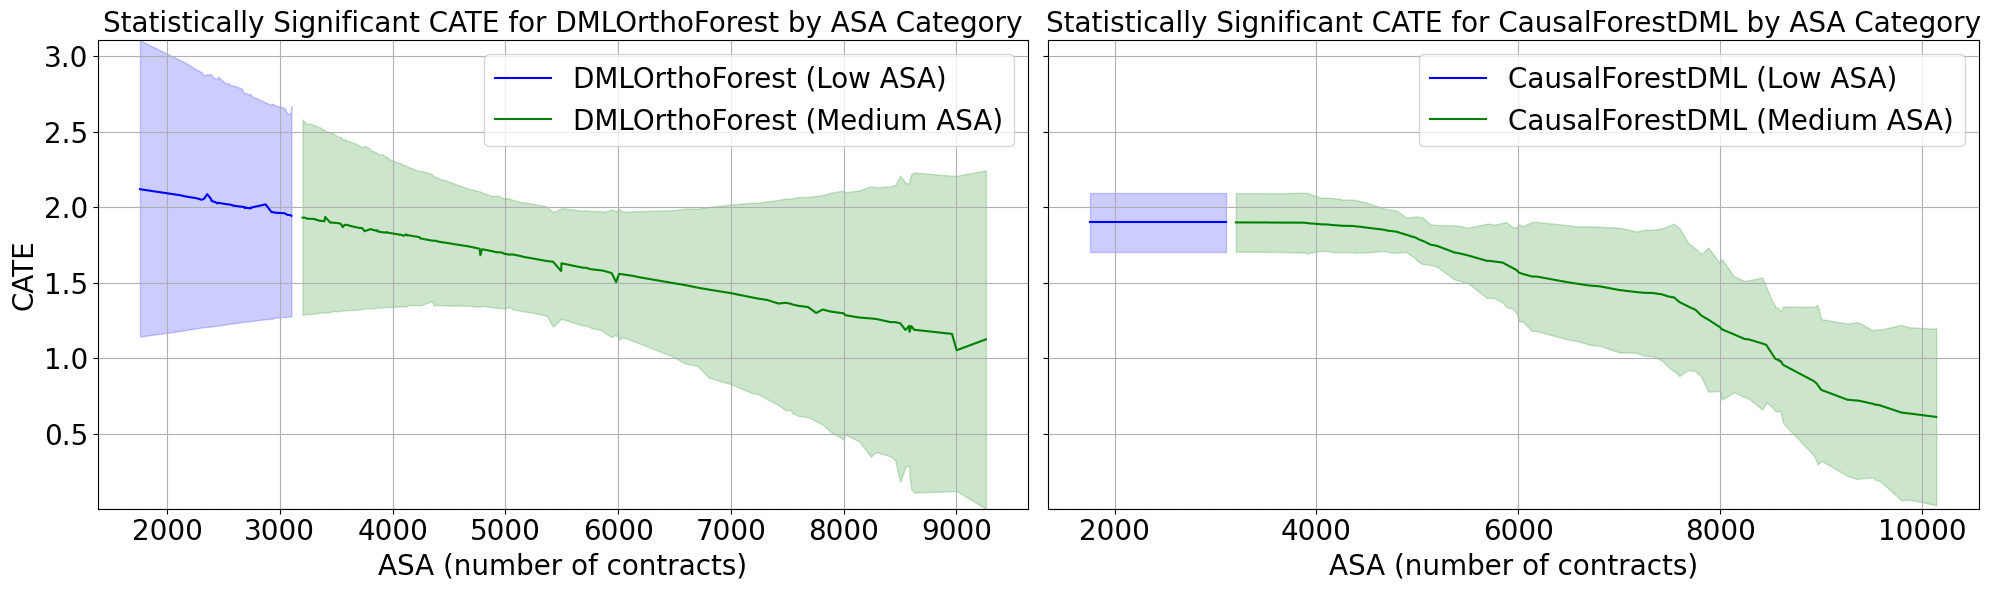

In [ ]:
est1, res1, treatment_effects1, te_lower1, te_upper1, est2, res2, treatment_effects2, te_lower2, te_upper2, p_values1, p_values2, X_test = evaluate_conditional_treatment_effect(oj_data, treatment, outcome, het, conf, low_asa_threshold, high_asa_threshold)

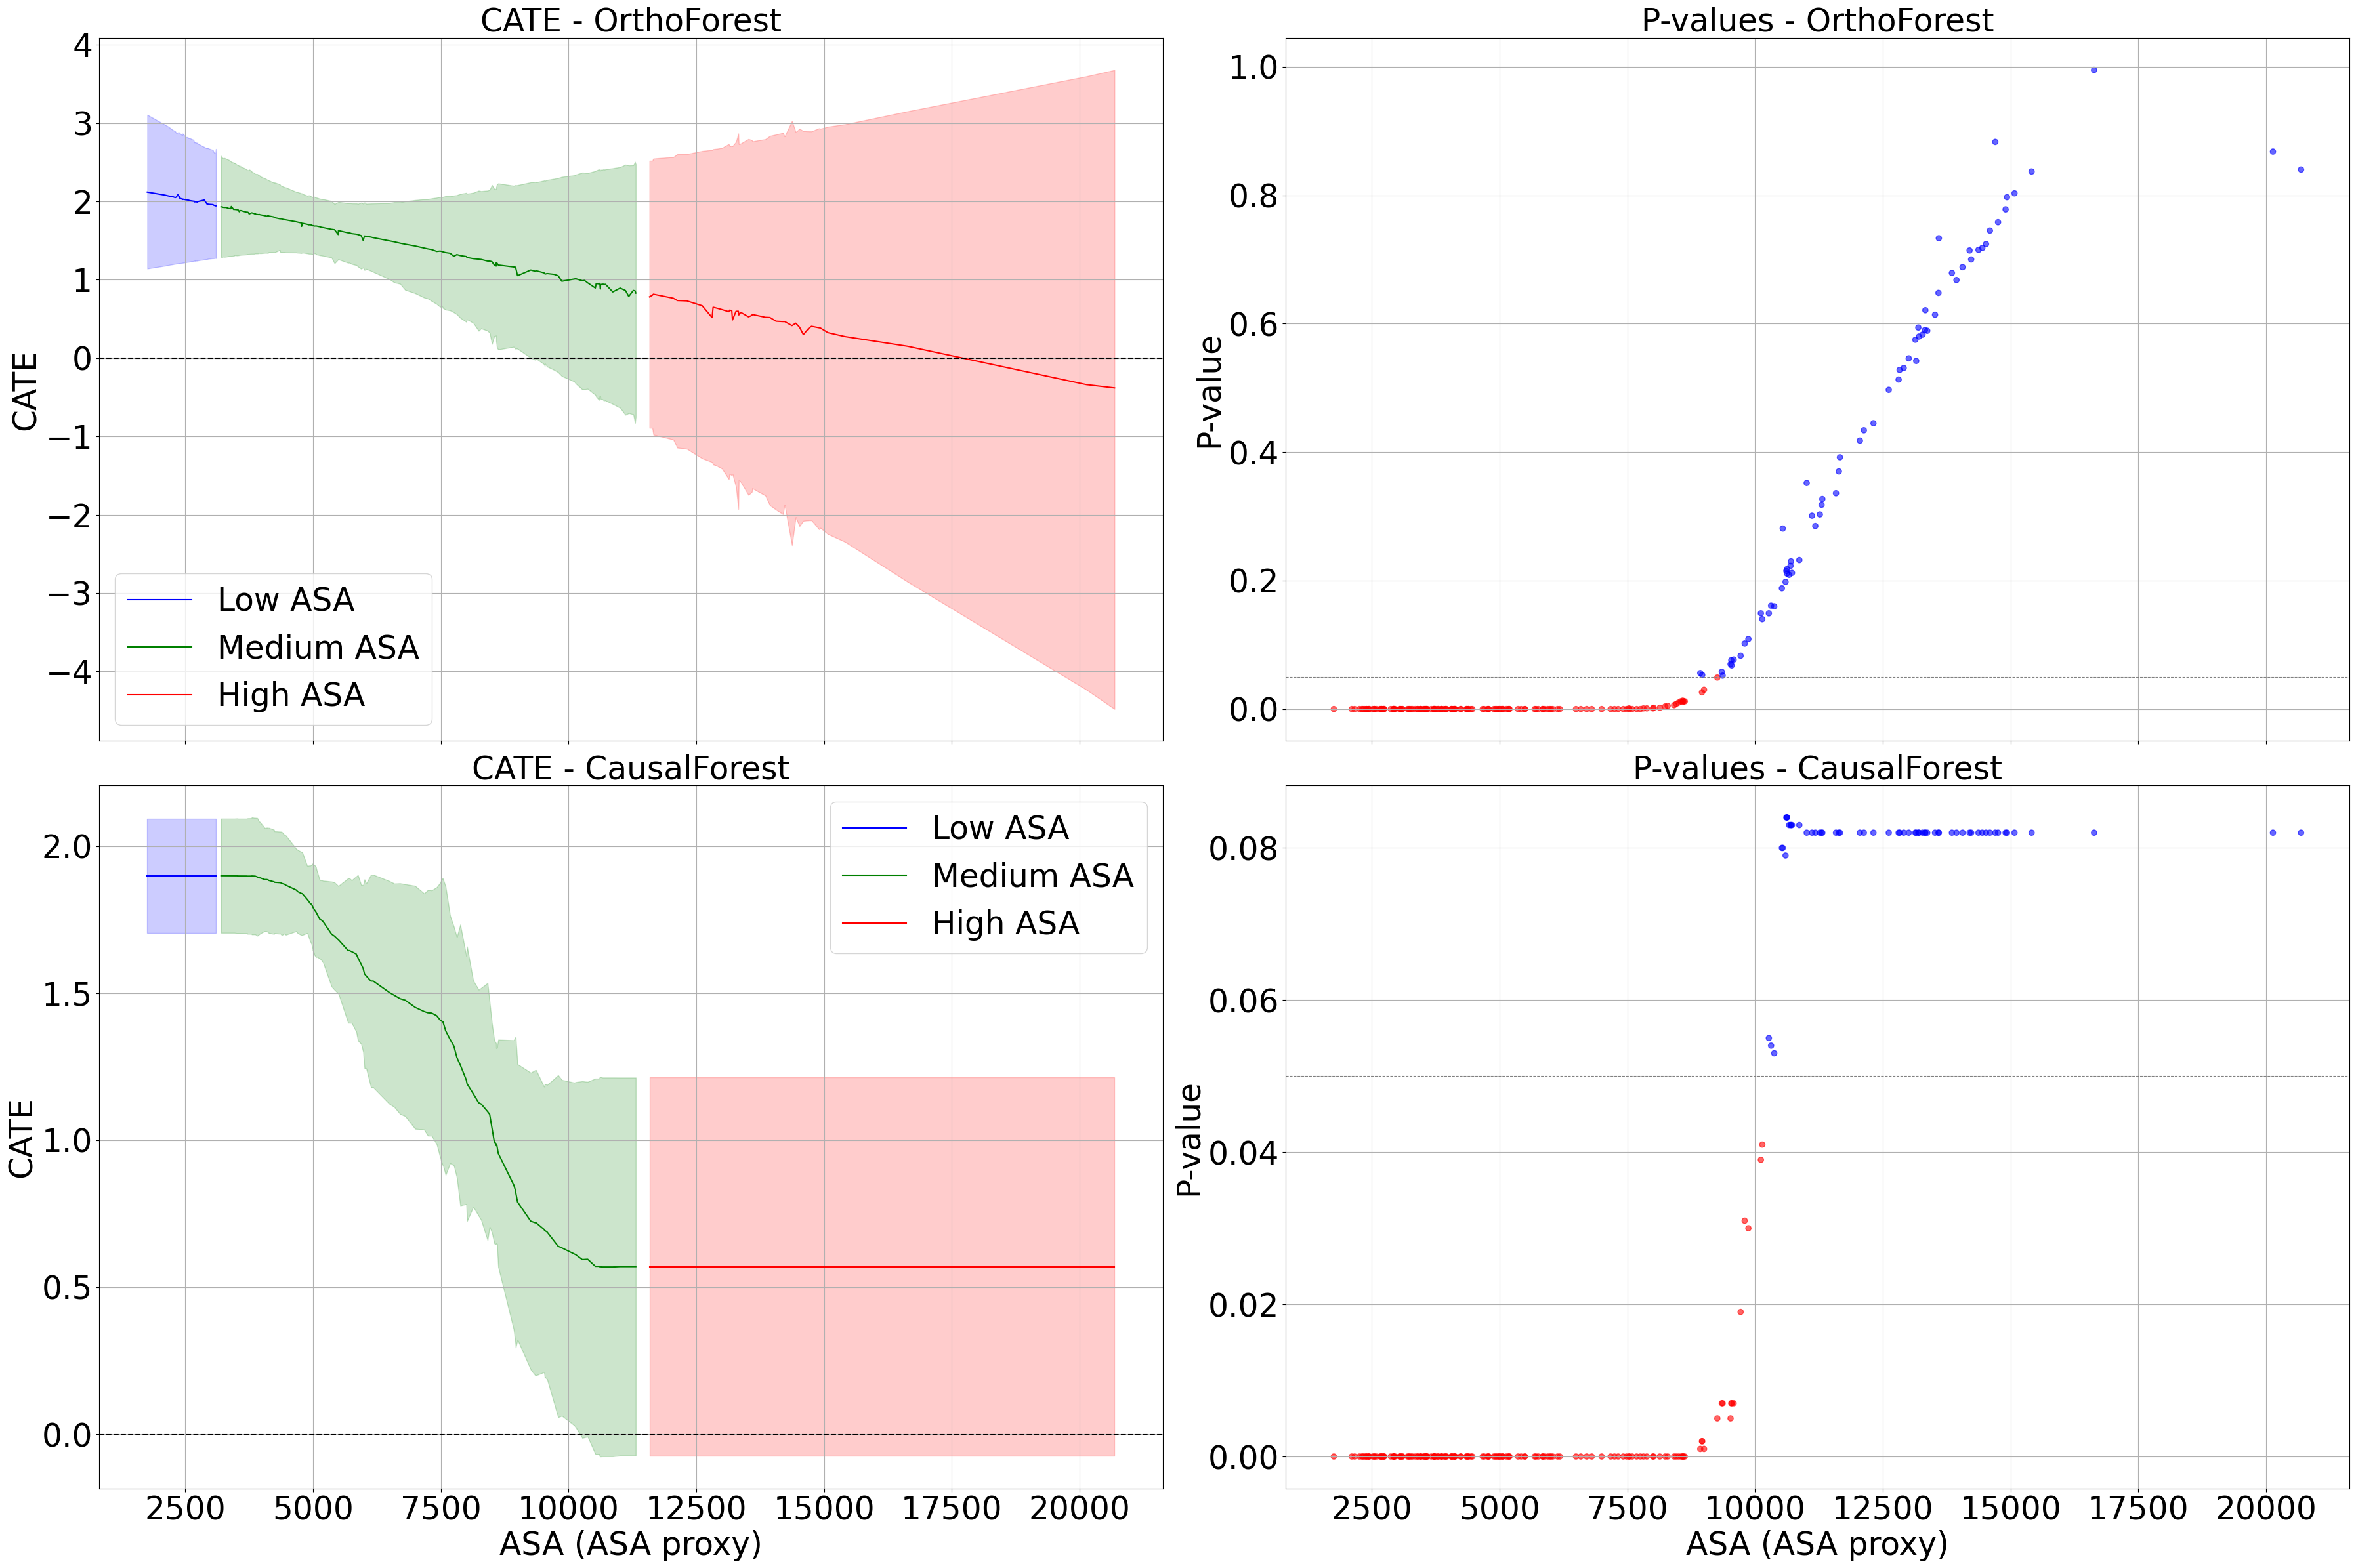

In [ ]:
plot_causal_inference(treatment_effects1, te_lower1, te_upper1, res1,
                          treatment_effects2, te_lower2, te_upper2, res2,
                          X_test, low_asa_threshold, high_asa_threshold, het)

In [ ]:
# Analyze the results for OrthoForest for each ASA category
results_ortho = analyze_asa_categories(treatment_effects1, te_lower1, te_upper1, X_test,
                                       low_asa_threshold, high_asa_threshold)
print("Risultati per DMLOrthoForest:")
results_ortho

Risultati per DMLOrthoForest:


,ASA_Category,Mean_CATE,Mean_CI_Lower,Mean_CI_Upper,Min_ASA,Max_ASA
0,High,0.489100,-1.835966,2.823603,11583.6,20682.25
1,Low,2.010664,1.233574,2.787363,1759.5,3102.25
2,Medium,1.486034,0.747501,2.232813,3201.6,11316.00


In [ ]:
# Analyze the results for CausalForest for each ASA category
results_causal = analyze_asa_categories(treatment_effects2, te_lower2, te_upper2, X_test,
                                        low_asa_threshold, high_asa_threshold)
print("Risultati per CausalForestDML:")
results_causal

Risultati per CausalForestDML:


,ASA_Category,Mean_CATE,Mean_CI_Lower,Mean_CI_Upper,Min_ASA,Max_ASA
0,High,0.570009,-0.072776,1.212794,11583.6,20682.25
1,Low,1.899202,1.705188,2.093215,1759.5,3102.25
2,Medium,1.417692,1.085692,1.749693,3201.6,11316.00


# Validation

## Comparing OrthoForest and CausalForest

In [ ]:
# Create a mask for significant pvalue for each model
mask = (p_values1 < 0.05) & (p_values2 < 0.05)

# Applica maschera
mean_cate_diff = treatment_effects1[mask] - treatment_effects2[mask]
upper_cate_diff = te_upper1[mask] - te_upper2[mask]
lower_cate_diff = te_lower1[mask] - te_lower2[mask]
asa_values = X_test.flatten()[mask]

print(f'Average difference: {np.mean(mean_cate_diff)} +- {np.std(mean_cate_diff)}')
print(f'Upper average difference: {np.mean(upper_cate_diff)}')
print(f'Lower average difference: {np.mean(lower_cate_diff)}')

Average difference: 0.014773240116799258 +- 0.10277215652132529
Upper average difference: 0.38487377293683156
Lower average difference: -0.35329369300926305


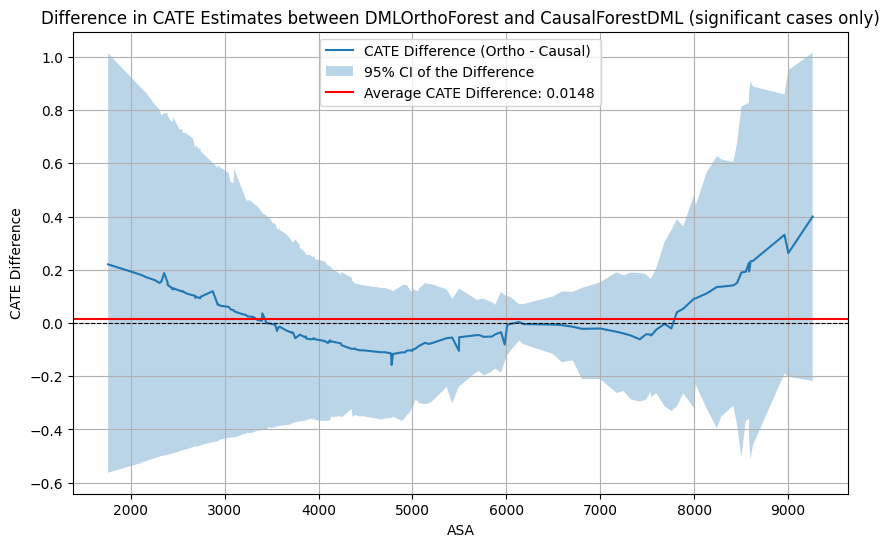

In [ ]:
mean_diff_avg = np.mean(mean_cate_diff)

plt.figure(figsize=(10, 6))

plt.plot(asa_values, mean_cate_diff, label='CATE Difference (Ortho - Causal)')
plt.fill_between(asa_values, lower_cate_diff, upper_cate_diff, alpha=0.3, label='95% CI of the Difference')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(mean_diff_avg, color='red', linestyle='-', linewidth=1.5, label=f'Average CATE Difference: {mean_diff_avg:.4f}')

plt.xlabel("ASA")
plt.ylabel("CATE Difference")
plt.title("Difference in CATE Estimates between DMLOrthoForest and CausalForestDML (significant cases only)")
plt.legend()
plt.grid(True)
plt.show()

## Placebo Test

To rule out spurious findings, we conducted a **placebo test** by replacing the original treatment variable with a randomized version. If the model is valid, the resulting treatment effects are expected to be close to zero and statistically insignificant.

In [ ]:
oj_data['placebo_treatment'] = np.random.rand(len(oj_data)) * 5 # Example: random values between 0 and 5

# Define variables for placebo test
treatment = 'placebo_treatment'
outcome = 'APU0000713111'
het = ['ASA']
conf = ['CUUR0000SAF114', 'PORANGUSDM', 'FPCPITOTLZGUSA', 'Volume','ASA', 'is_hurricane', 'is_frost', 'is_good_period', 'Close_Converted']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   38.6s finished
[Parallel(n_jobs=-1)]: Using backend

ATE for OrthoForest: nan±nan
ATE for CausalForest: nan±nan


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


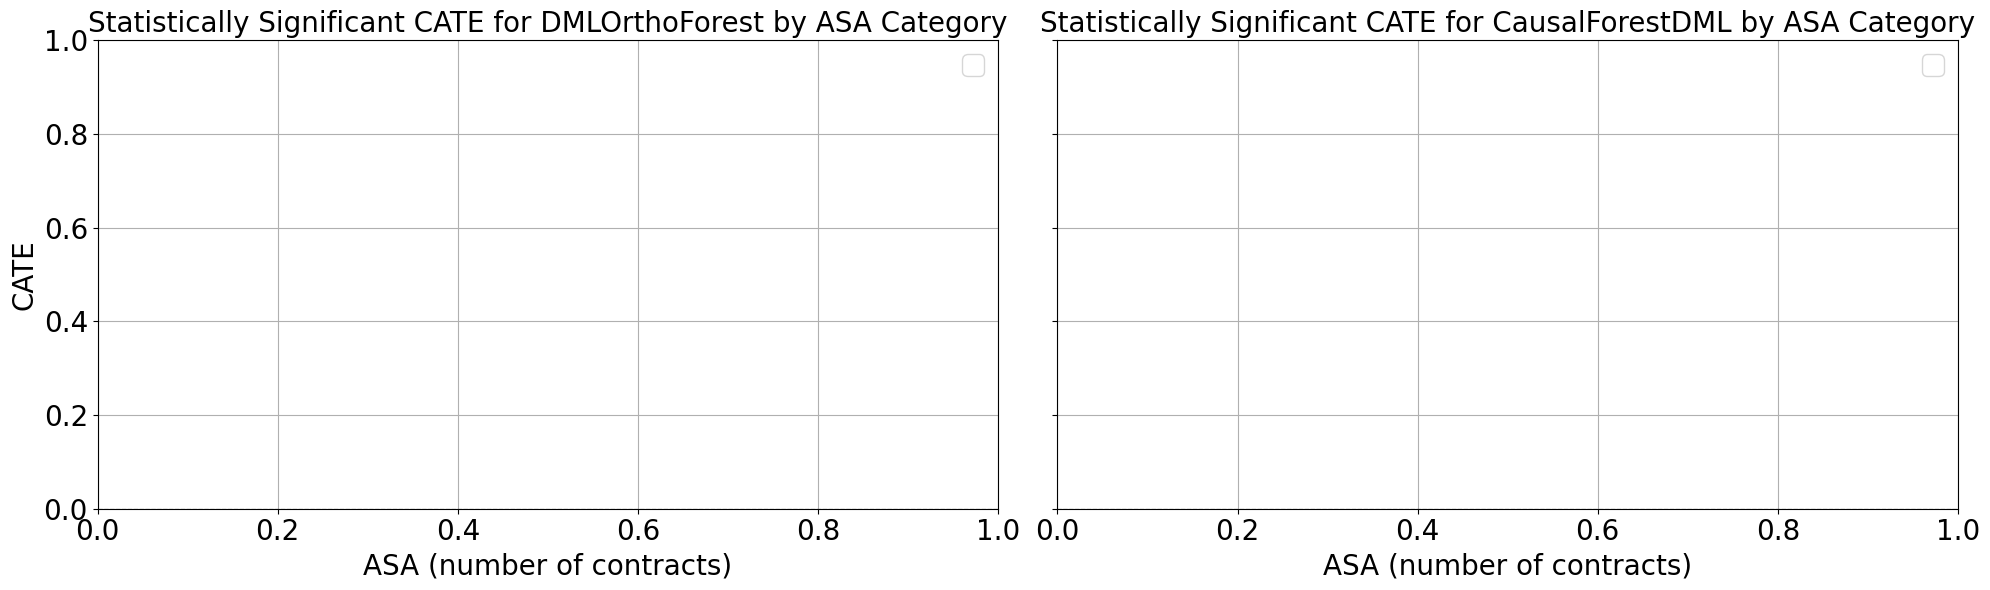

In [ ]:
# Run the causal inference with the placebo treatment
est1, res1, treatment_effects1, te_lower1, te_upper1, est2, res2, treatment_effects2, te_lower2, te_upper2, p_values1, p_values2, X_test = evaluate_conditional_treatment_effect(oj_data, treatment, outcome, het, conf, low_asa_threshold, high_asa_threshold)

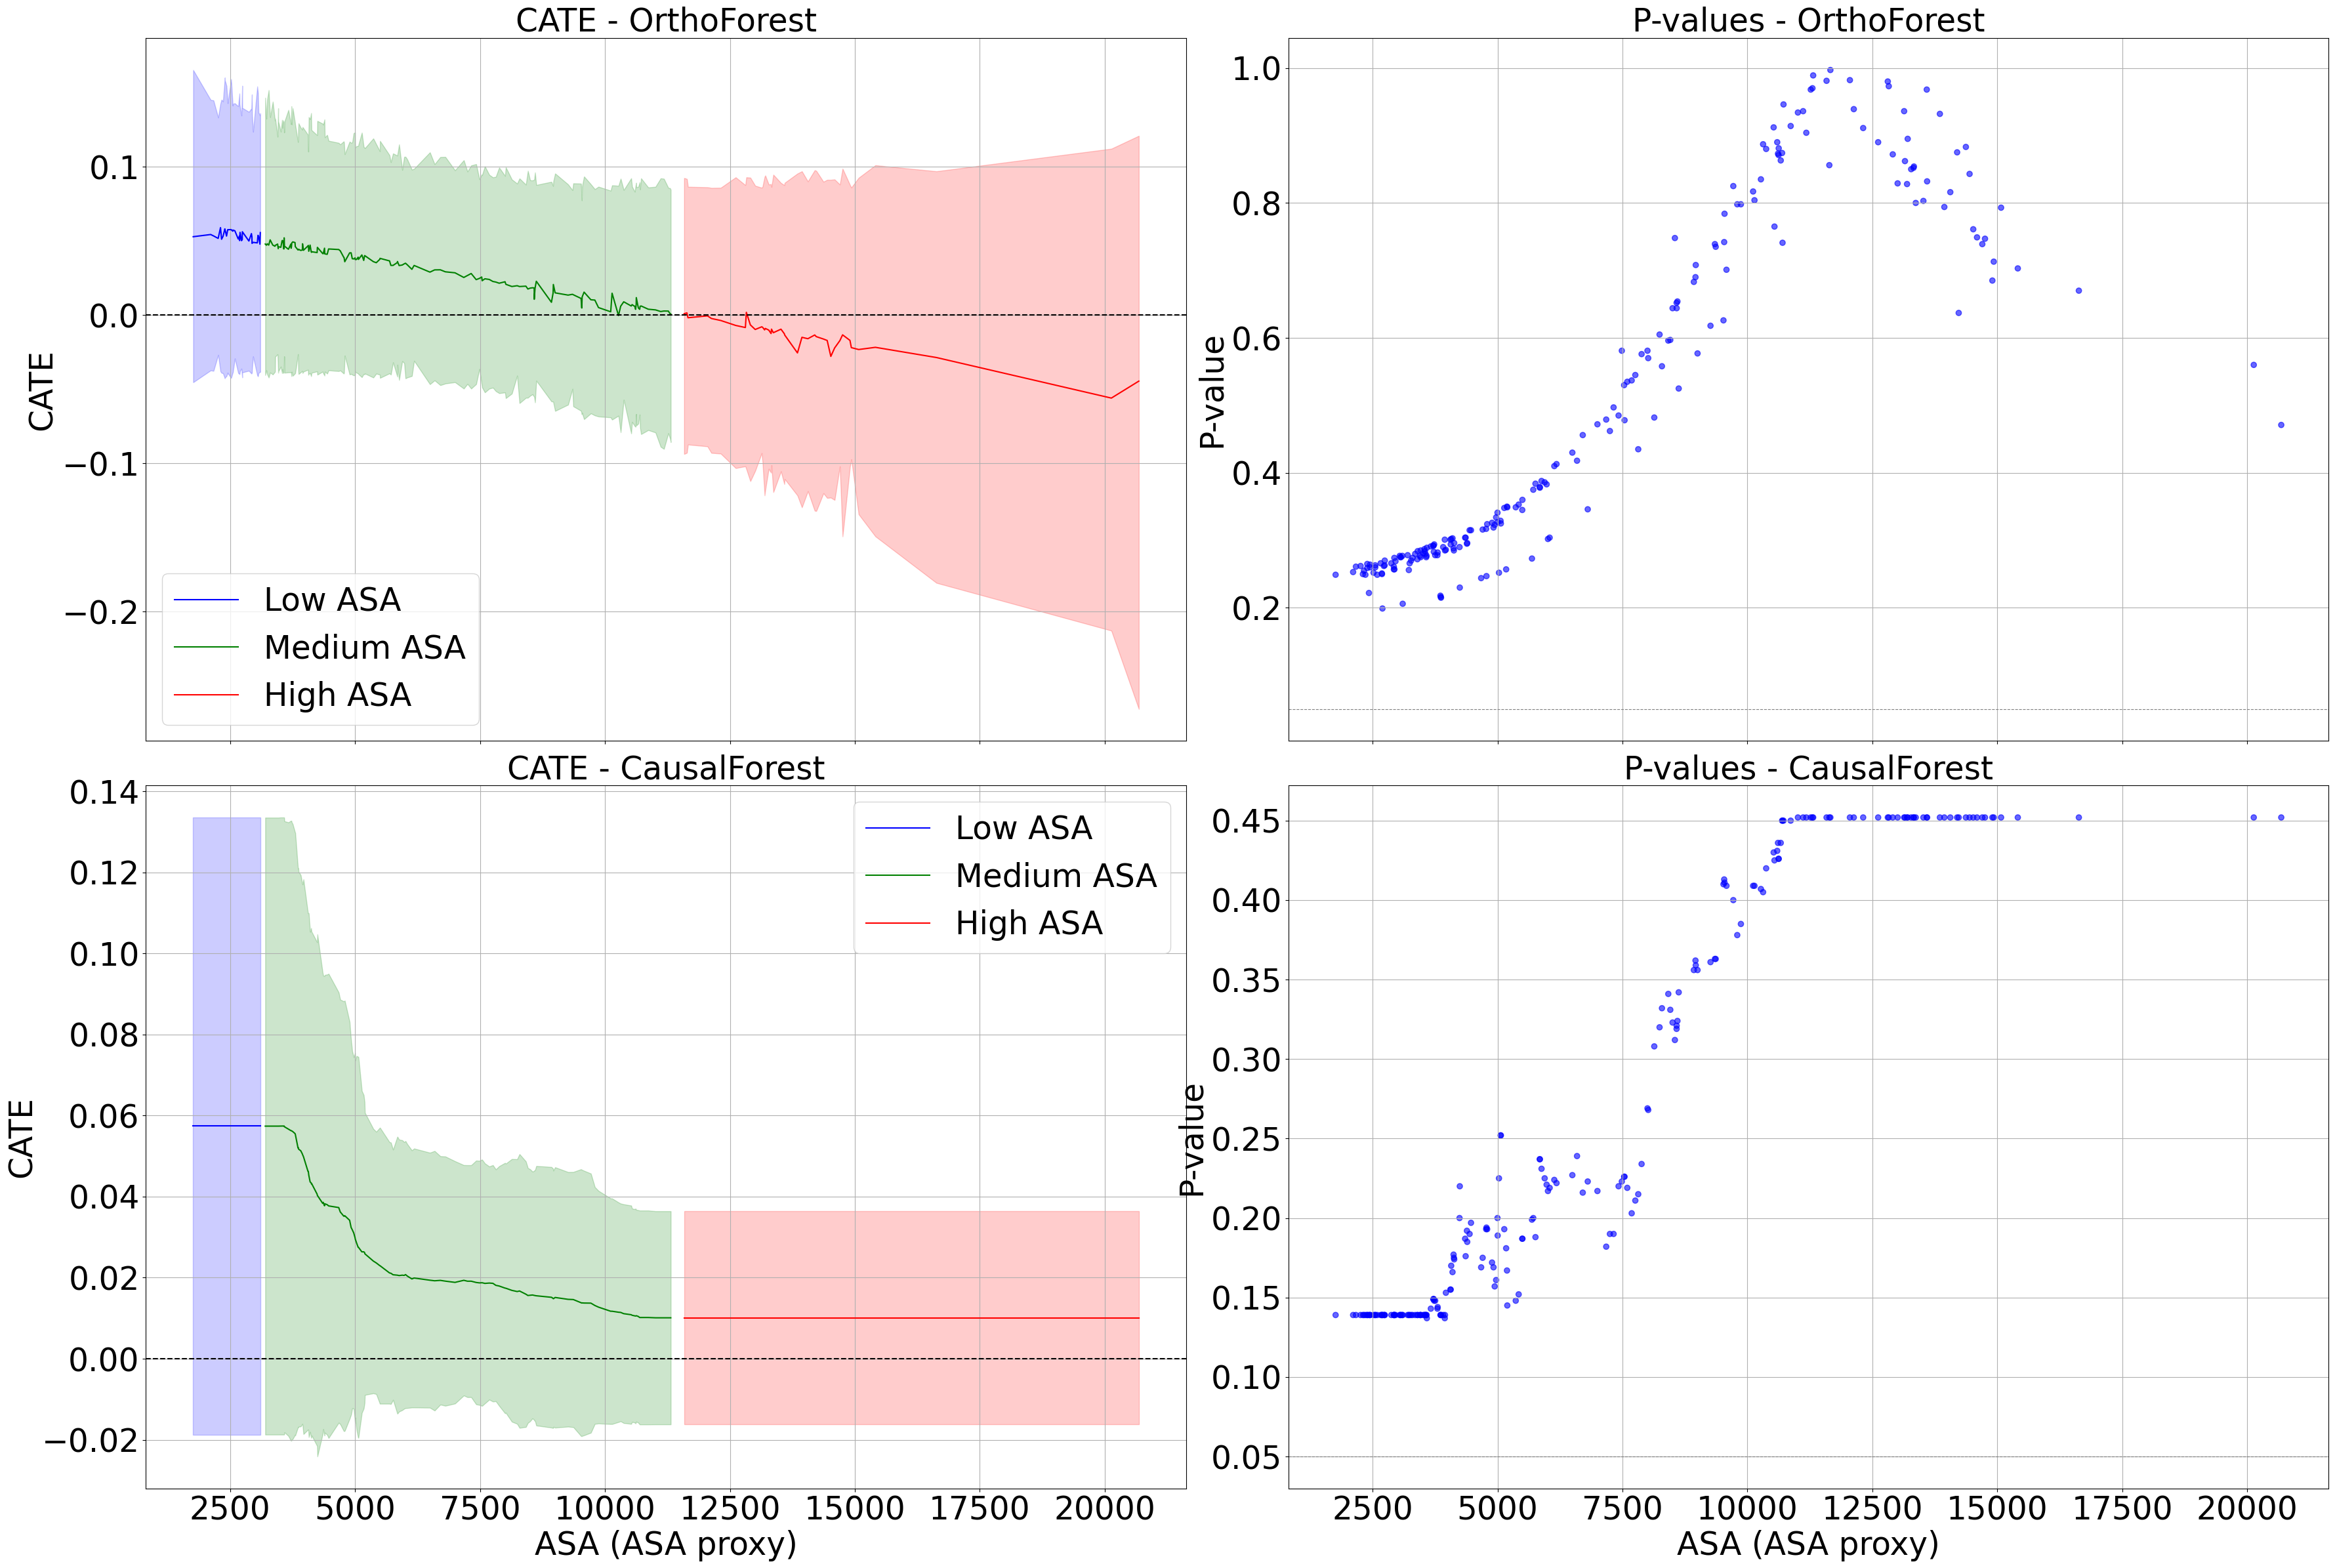

In [ ]:
plot_causal_inference(treatment_effects1, te_lower1, te_upper1, res1,
                          treatment_effects2, te_lower2, te_upper2, res2,
                          X_test, low_asa_threshold, high_asa_threshold, het)

## Robustness Analysis

We performed a robustness analysis by varying key hyperparameters of the causal forest models, including the `number of trees, minimum leaf size, maximum depth, and subsample ratio`.

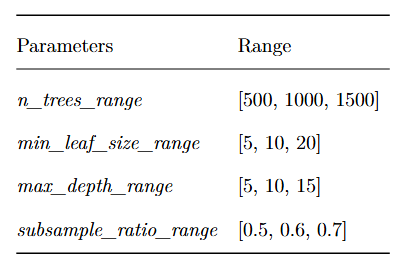

### Useful functions

In [ ]:
def sensitivity_analysis(oj_data, treatment, outcome, het, conf, model, n_trees = 1000, min_leaf_size = 10, max_depth = 10, subsample_ratio = 0.6):
  # Treatment: variation of future prices
  T = oj_data[treatment].values[:]

  # Outcome: variation of spot prices
  Y = oj_data[outcome].values[:]

  # Mediator: ASA
  X = oj_data[het].values[:]

  # Confoundings: inflation, volume of future contracts, cpi, etc...
  W = oj_data[conf].values[:]

  # Standardize W
  scaler = StandardScaler()
  W = scaler.fit_transform(W)

  if model.lower() == 'ortho':
    est = DMLOrthoForest(
            n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth,
            subsample_ratio=subsample_ratio,
            model_T=Lasso(alpha=0.1),
            model_Y=Lasso(alpha=0.1),
            model_T_final=WeightedLassoCVWrapper(cv=3),
            model_Y_final=WeightedLassoCVWrapper(cv=3),
            random_state=123
          )
  else:
    est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                          model_t=WeightedLassoCVWrapper(cv=3),
                          n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                          max_samples=subsample_ratio/2,
                          random_state=123)

  est.fit(Y, T, X=X, W=W)

  # Define the X test by sorting the mediator values
  X_test_raw = oj_data[het].values[:]
  X_test = X_test_raw[np.argsort(X_test_raw.flatten())]

  # Calculate marginal treatment effects
  treatment_effects = est.const_marginal_effect(X_test)

  # Calculate default (95%) marginal confidence intervals for the test data
  te_lower, te_upper = est.const_marginal_effect_interval(X_test)

  res = est.effect_inference(X_test)

  # ===== PLOT =====
  fontsize=20
  plt.figure(figsize=(12, 6))

  plt.plot(X_test.flatten(), treatment_effects, label=f"OJ Effetto di {treatment} su {outcome}")
  plt.fill_between(X_test.flatten(), te_lower, te_upper, label="95% BLB CI", alpha=0.3)

  plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
  plt.xlabel(f"{het[0]}", fontsize=fontsize)
  plt.ylabel("CATE", fontsize=fontsize)
  plt.legend(fontsize=fontsize)
  plt.tick_params(axis='both', labelsize=fontsize)
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return res, treatment_effects, te_lower, te_upper, X_test

In [ ]:
def sensitivity_analysis_hyperparams(oj_data, treatment, outcome, het, conf):
    """
    Performs sensitivity analysis by varying hyperparameters for DMLOrthoForest
    and CausalForestDML models and plots the CATE estimates.

    Args:
        oj_data (pd.DataFrame): The dataset.
        treatment (str): Name of the treatment column.
        outcome (str): Name of the outcome column.
        het (list): List of heterogeneity variables columns.
        conf (list): List of confounding variables columns.
    """
    # Define ranges of hyperparameters to test
    n_trees_range = [500, 1000, 1500]
    min_leaf_size_range = [5, 10, 20]
    max_depth_range = [5, 10, 15]
    subsample_ratio_range = [0.5, 0.6, 0.7]

    param_grid = list(product(n_trees_range, min_leaf_size_range, max_depth_range, subsample_ratio_range))

    results = {}

    for model_name in ['ortho', 'causal']:
        results[model_name] = {}
        for n_trees, min_leaf_size, max_depth, subsample_ratio in param_grid:
            params = (n_trees, min_leaf_size, max_depth, subsample_ratio)
            print(f"Running {model_name} with params: n_trees={n_trees}, min_leaf_size={min_leaf_size}, max_depth={max_depth}, subsample_ratio={subsample_ratio}")

            # Run the causal inference with specified hyperparameters
            # We don't need the full output of causal_inference here, just the treatment effects and X_test
            _, treatment_effects, _, _, X_test = sensitivity_analysis(
                oj_data, treatment, outcome, het, conf, model_name,
                n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth,
                subsample_ratio=subsample_ratio
            )

            # Store the CATE for this parameter set, keyed by the parameters
            results[model_name][params] = treatment_effects

    # Plotting the results for sensitivity analysis
    X_test_flat = X_test.flatten()

    plt.figure(figsize=(18, 8))

    # Plot for OrthoForest
    ax1 = plt.subplot(1, 2, 1)
    for params, cates in results['ortho'].items():
        label = f'n_trees={params[0]}, min_leaf={params[1]}, max_depth={params[2]}, subsample={params[3]}'
        ax1.plot(X_test_flat, cates, alpha=0.5, label=label)
    ax1.set_xlabel(f"{het[0]}")
    ax1.set_ylabel("CATE")
    ax1.set_title("Sensitivity Analysis: DMLOrthoForest CATE with Varying Hyperparameters")
    ax1.grid(True)
    # ax1.legend(fontsize=6) # Optional: uncomment to show legend

    # Plot for CausalForest
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    for params, cates in results['causal'].items():
         label = f'n_trees={params[0]}, min_leaf={params[1]}, max_depth={params[2]}, subsample={params[3]}'
         ax2.plot(X_test_flat, cates, alpha=0.5, label=label)
    ax2.set_xlabel(f"{het[0]}")
    ax2.set_title("Sensitivity Analysis: CausalForestDML CATE with Varying Hyperparameters")
    ax2.grid(True)
    # ax2.legend(fontsize=6) # Optional: uncomment to show legend

    plt.tight_layout()
    plt.show()

    print("\nSensitivity Analysis Results:")
    for model_name, param_results in results.items():
        print(f"\n--- {model_name} ---")
        # Calculate and print mean and std deviation of CATE across hyperparameter sets for each X value
        cates_matrix = np.vstack(list(param_results.values()))
        mean_cates = np.mean(cates_matrix, axis=0)
        std_cates = np.std(cates_matrix, axis=0)

        print(f"Average CATE across hyperparameters (mean ± std):")
        # Print for a few representative points of X_test
        indices_to_print = [0, len(X_test_flat)//4, len(X_test_flat)//2, len(X_test_flat)*3//4, -1]
        for i in indices_to_print:
            print(f"  X={X_test_flat[i]:.2f}: CATE = {mean_cates[i]:.4f} ± {std_cates[i]:.4f}")

        # You can also visualize the variability if needed, e.g., box plots for a few X values
    return results, param_grid

In [ ]:
def plot_causal_subplots_from_lists(model1, model2, X_test, low_asa_threshold, high_asa_threshold, het):
    asa_values = X_test.flatten()

    # ASA category definition
    asa_categories = [
        'Low' if val <= low_asa_threshold else
        'High' if val >= high_asa_threshold else
        'Medium'
        for val in asa_values
    ]

    category_colors = {'Low': 'blue', 'Medium': 'green', 'High': 'red'}

    def get_mean_std_rmse(model):
        arr = np.array(model)  # shape: (num_runs, num_points)
        mean = arr.mean(axis=0)
        std = arr.std(axis=0)
        rmse = np.sqrt(((arr - mean) ** 2).mean(axis=0))
        rmse_std = np.std(np.sqrt((arr - mean) ** 2), axis=0)
        return mean, std, rmse, rmse_std

    mean1, std1, rmse1, rmse_std1 = get_mean_std_rmse(model1)
    mean2, std2, rmse2, rmse_std2 = get_mean_std_rmse(model2)

    df1 = pd.DataFrame({
        'ASA': asa_values,
        'CATE': mean1,
        'CI_Lower': mean1 - std1,
        'CI_Upper': mean1 + std1,
        'RMSE': rmse1,
        'RMSE_Lower': rmse1 - rmse_std1,
        'RMSE_Upper': rmse1 + rmse_std1,
        'ASA_Category': asa_categories
    }).sort_values('ASA')

    df2 = pd.DataFrame({
        'ASA': asa_values,
        'CATE': mean2,
        'CI_Lower': mean2 - std2,
        'CI_Upper': mean2 + std2,
        'RMSE': rmse2,
        'RMSE_Lower': rmse2 - rmse_std2,
        'RMSE_Upper': rmse2 + rmse_std2,
        'ASA_Category': asa_categories
    }).sort_values('ASA')

    fig, axes = plt.subplots(2, 2, figsize=(36, 24), sharex=True)
    fontsize= 25

    def plot_cate(ax, df, title):
        for category in ['Low', 'Medium', 'High']:
            cat_df = df[df['ASA_Category'] == category]
            if not cat_df.empty:
                ax.plot(cat_df['ASA'], cat_df['CATE'], label=f'{category} ASA', color=category_colors[category])
                ax.fill_between(cat_df['ASA'], cat_df['CI_Lower'], cat_df['CI_Upper'], color=category_colors[category], alpha=0.2)
        ax.set_ylabel('CATE', fontsize=fontsize)
        ax.set_title(title, fontsize=fontsize)
        ax.grid(True)
        ax.legend(fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)

    def plot_rmse(ax, df, title):
        ax.plot(df['ASA'], df['RMSE'], color='orange', label='RMSE')
        ax.fill_between(df['ASA'], df['RMSE_Lower'], df['RMSE_Upper'], color='orange', alpha=0.2, label='±1 std')
        ax.set_ylabel('RMSE', fontsize=fontsize)
        ax.set_title(title, fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)
        ax.grid(True)
        ax.legend(fontsize=fontsize)

    plot_cate(axes[0, 0], df1, "CATE - OrthoForest")
    plot_rmse(axes[0, 1], df1, "CATE RMSE - OrthoForest")

    plot_cate(axes[1, 0], df2, "CATE - CausalForest")
    plot_rmse(axes[1, 1], df2, "CATE RMSE - CausalForest")

    for ax in axes[1]:
        ax.set_xlabel(f"{het[0]} (ASA proxy)", fontsize=fontsize)

    plt.tight_layout()
    plt.show()

### Perform the test

In [ ]:
results, param_grid = sensitivity_analysis_hyperparams(oj_data, treatment, outcome, het, conf)

Output hidden; open in https://colab.research.google.com to view.

Save the results

In [ ]:
import json

results_to_save = {
    'ortho': {},
    'causal': {}
}

# Convert NumPy arrays to lists for JSON serialization
for model_name, param_results in results.items():
    for params, cates in param_results.items():
        # Ensure keys (params tuple) are JSON serializable, convert to string if necessary
        param_key = str(params)
        results_to_save[model_name][param_key] = cates.tolist()

# Convert X_test (last value from the loop) to list as well for saving
# Note: X_test will be the same for all runs since the input data isn't changing
if 'X_test' in locals():
  results_to_save['X_test'] = X_test.flatten().tolist()

# Define the filename to save the results
output_filename = 'causal_inference_robustness_results.json'

# Save the dictionary to a JSON file
with open(output_filename, 'w') as f:
    json.dump(results_to_save, f)

print(f"Results saved on the file: {output_filename}")

Results saved on the file: causal_inference_robustness_results.json


### Upload the results

In [3]:
import json

output_filename = 'causal_inference_robustness_results.json'

# Load the data from the JSON file
try:
    with open(output_filename, 'r') as f:
        results = json.load(f)
    print(f"File '{output_filename}' uploaded successfully.")

except FileNotFoundError:
    print(f"Error: The file '{output_filename}' was not found.")
    results = None
except json.JSONDecodeError:
    print(f"Error: Impossible decoding the file '{output_filename}' as a JSON.")
    results = None

File 'causal_inference_robustness_results.json' uploaded successfully.


### Plot

In [7]:
model1 = list(results['ortho'].values())
model2 = list(results['causal'].values())

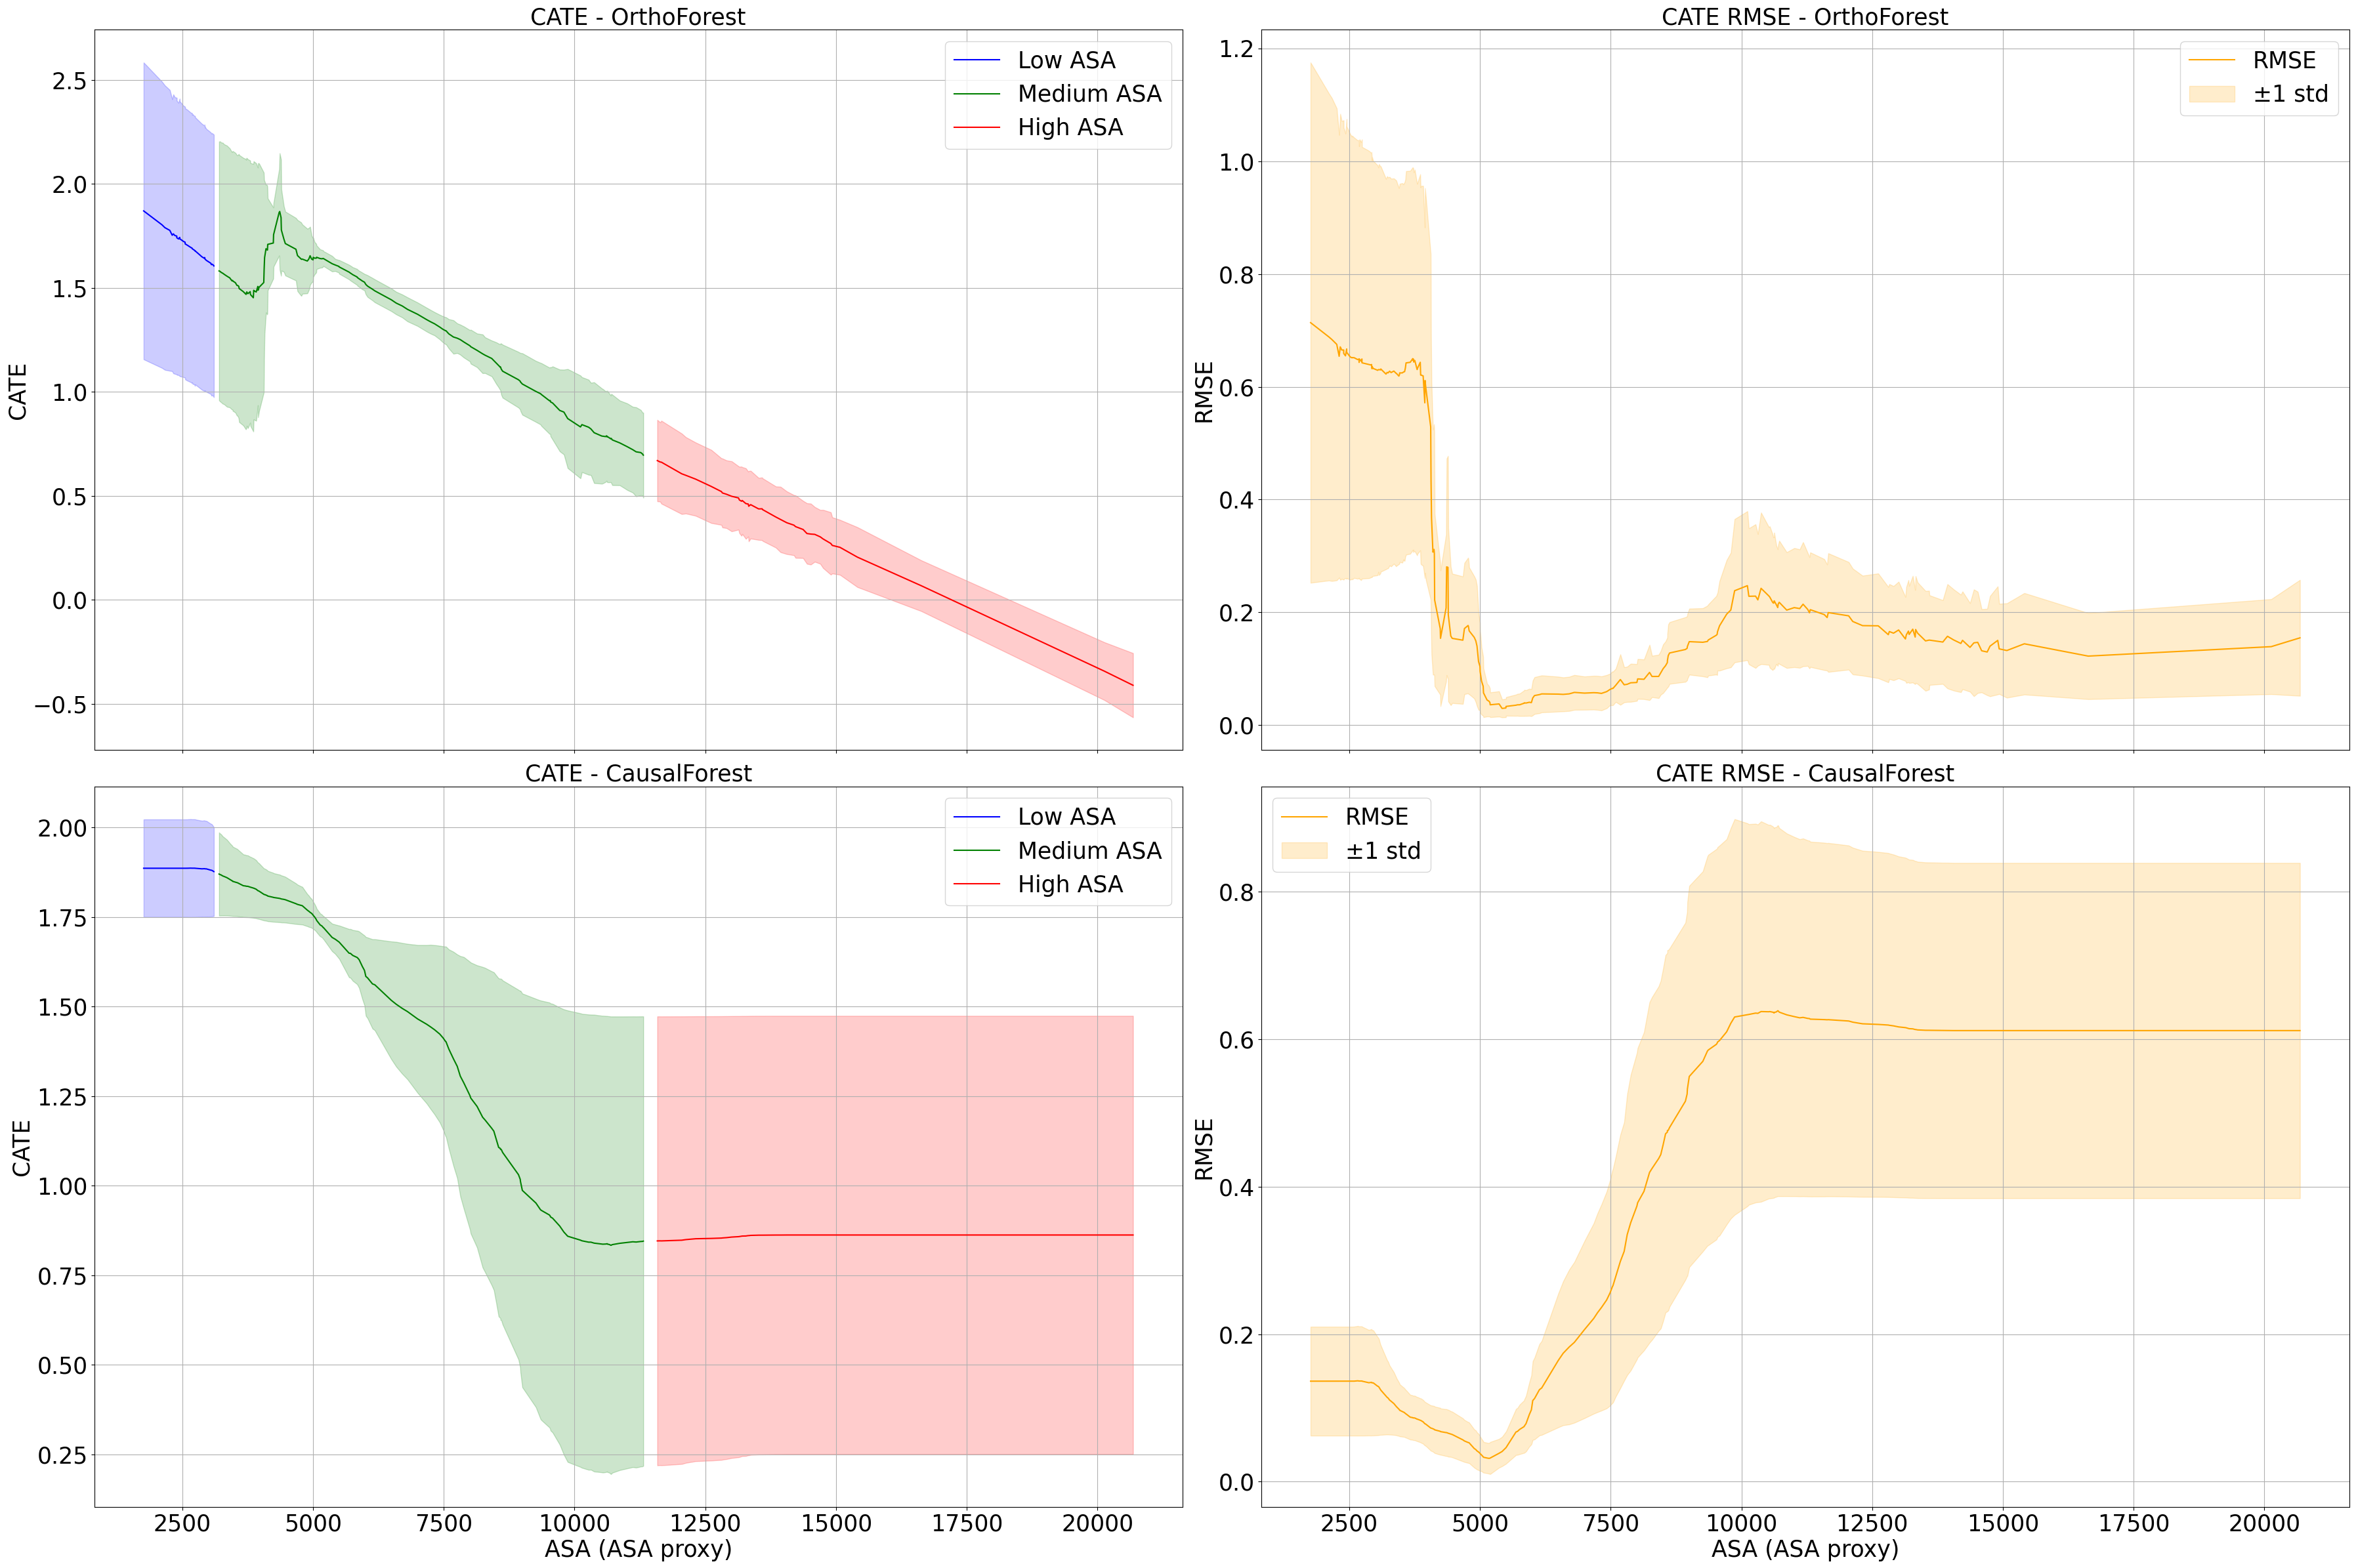

In [ ]:
plot_causal_subplots_from_lists(model1, model2, X_test, low_asa_threshold, high_asa_threshold, het)